In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc,
    roc_auc_score,
)
from statsmodels.stats.contingency_tables import mcnemar

In [2]:
# Function for preprocessing
def preprocess_data(filepath):
    # Load dataset
    data = pd.read_csv(filepath)
    
    # Check for missing values and print counts
    print(f"Missing values in 'Age': {data['Age'].isna().sum()}")
    print(f"Missing values in 'Pclass': {data['Pclass'].isna().sum()}")
    print(f"Missing values in 'Sex': {data['Sex'].isna().sum()}")
    print(f"Missing values in 'Embarked': {data['Embarked'].isna().sum()}")
    print(f"Missing values in 'Parch': {data['Parch'].isna().sum()}")
    print(f"Missing values in 'SibSp': {data['SibSp'].isna().sum()}")
    print(f"Missing values in 'Fare': {data['Fare'].isna().sum()}")
    
    # Impute missing values
    # Fill missing values in 'Age' with the median
    age_imputer = SimpleImputer(strategy="median")
    data["Age"] = age_imputer.fit_transform(data[["Age"]])
    
    # Fill missing values in 'Embarked' with the most common value
    if data["Embarked"].isnull().sum() > 0:
        embarked_imputer = SimpleImputer(strategy="most_frequent")
        data["Embarked"] = embarked_imputer.fit_transform(data[["Embarked"]]).ravel()
    
    # Apply log-transform to 'Fare' to reduce skewness
    data["Fare"] = np.log1p(data["Fare"])
    print("Applied log-transform to 'Fare' column.")

    # Drop irrelevant columns
    data = data.drop(columns=["PassengerId", "Name", "Ticket", "Cabin"])
    
    # Encode categorical variables
    data = pd.get_dummies(data, columns=["Sex", "Embarked", "Pclass"], drop_first=True)

    # Split features and target
    X = data.drop(columns=["Survived"])
    y = data["Survived"]

    # Store feature names before scaling
    feature_names = X.columns.tolist()
    
    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale numerical features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    print("Preprocessing completed.")
    return X_train_scaled, X_test_scaled, y_train, y_test, feature_names

In [3]:
# Function for training and evaluating models
def train_evaluate_model(model, model_name, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Calculate metrics
    train_accuracy = accuracy_score(y_train, y_pred_train)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    classification_rep = classification_report(y_test, y_pred_test, output_dict=True)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]) if hasattr(model, "predict_proba") else None

    print(f"{model_name} Training Accuracy: {train_accuracy:.2f}")
    print(f"{model_name} Testing Accuracy: {test_accuracy:.2f}")
    print(f"\nClassification Report for {model_name} on Test Set:")
    print(classification_report(y_test, y_pred_test))

    return {
        "Model": model_name,
        "Test Accuracy": test_accuracy,
        "Precision (Survived)": classification_rep["1"]["precision"],
        "Recall (Survived)": classification_rep["1"]["recall"],
        "F1-Score (Survived)": classification_rep["1"]["f1-score"],
        "ROC-AUC": roc_auc,
    }

In [4]:
# Function for plotting confusion matrix and ROC curve
def plot_metrics(model, model_name, X_test, y_test):
    y_pred_test = model.predict(X_test)
    conf_matrix = confusion_matrix(y_test, y_pred_test)
    ConfusionMatrixDisplay(conf_matrix, display_labels=["Not Survived", "Survived"]).plot(cmap="Blues")
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()

    if hasattr(model, "predict_proba"):
        y_prob_test = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob_test)
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
        plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve for {model_name}")
        plt.legend(loc="lower right")
        plt.show()

In [5]:
# Preprocess the data
X_train_scaled, X_test_scaled, y_train, y_test, feature_names = preprocess_data("titanic.csv")

Missing values in 'Age': 177
Missing values in 'Pclass': 0
Missing values in 'Sex': 0
Missing values in 'Embarked': 2
Missing values in 'Parch': 0
Missing values in 'SibSp': 0
Missing values in 'Fare': 0
Applied log-transform to 'Fare' column.
Preprocessing completed.


Baseline (Most Frequent) Training Accuracy: 0.62
Baseline (Most Frequent) Testing Accuracy: 0.59

Classification Report for Baseline (Most Frequent) on Test Set:
              precision    recall  f1-score   support

           0       0.59      1.00      0.74       105
           1       0.00      0.00      0.00        74

    accuracy                           0.59       179
   macro avg       0.29      0.50      0.37       179
weighted avg       0.34      0.59      0.43       179



/Users/ignacioripollgonzalez/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ignacioripollgonzalez/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ignacioripollgonzalez/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

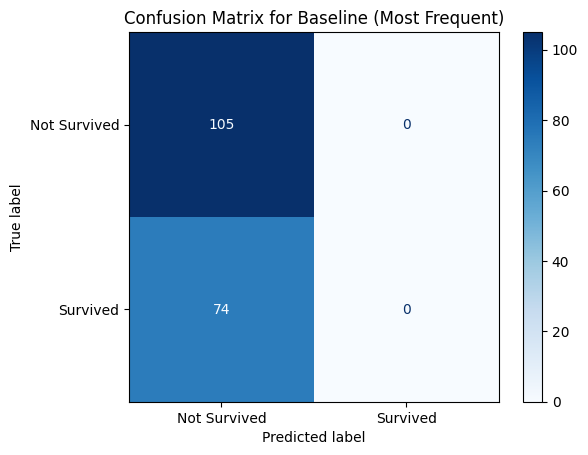

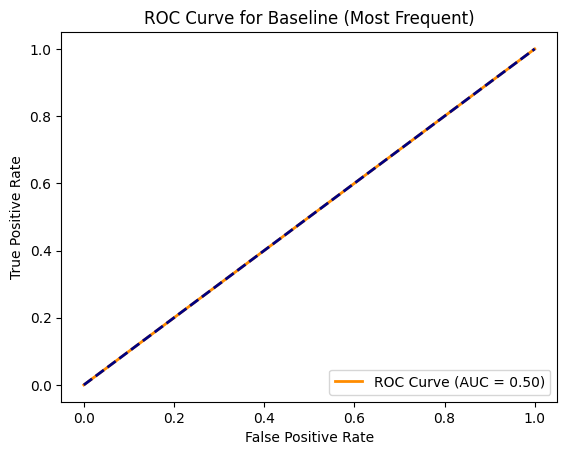

In [6]:
# Baseline Model
baseline_model = DummyClassifier(strategy="most_frequent")
baseline_metrics = train_evaluate_model(
    baseline_model, "Baseline (Most Frequent)", X_train_scaled, X_test_scaled, y_train, y_test
)
plot_metrics(baseline_model, "Baseline (Most Frequent)", X_test_scaled, y_test)

Logistic Regression (lambda=1.0) Training Accuracy: 0.81
Logistic Regression (lambda=1.0) Testing Accuracy: 0.80

Classification Report for Logistic Regression (lambda=1.0) on Test Set:
              precision    recall  f1-score   support

           0       0.81      0.86      0.83       105
           1       0.78      0.72      0.75        74

    accuracy                           0.80       179
   macro avg       0.80      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179



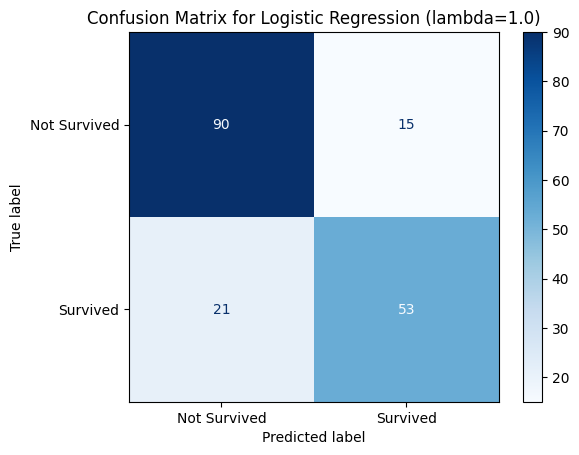

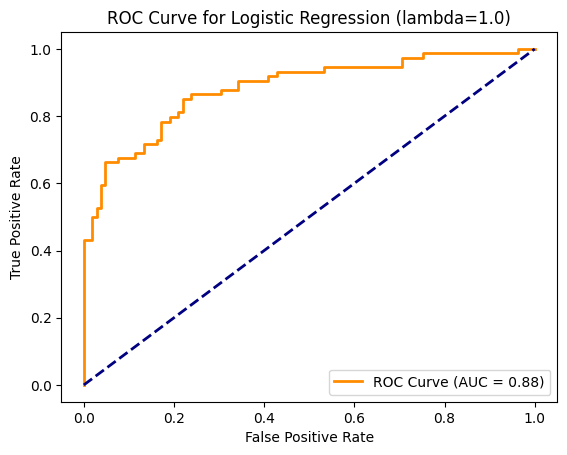

In [7]:
# Logistic Regression (lambda=1)
def_lambda = 1.0
logistic_regression_model = LogisticRegression(C=1/def_lambda, random_state=42, max_iter=1000)
logistic_metrics = train_evaluate_model(
    logistic_regression_model, f"Logistic Regression (lambda={def_lambda})", X_train_scaled, X_test_scaled, y_train, y_test
)
plot_metrics(logistic_regression_model, f"Logistic Regression (lambda={def_lambda})", X_test_scaled, y_test)

Artificial Neural Network (max_iter=200) Training Accuracy: 0.85
Artificial Neural Network (max_iter=200) Testing Accuracy: 0.83

Classification Report for Artificial Neural Network (max_iter=200) on Test Set:
              precision    recall  f1-score   support

           0       0.81      0.91      0.86       105
           1       0.85      0.70      0.77        74

    accuracy                           0.83       179
   macro avg       0.83      0.81      0.82       179
weighted avg       0.83      0.83      0.82       179



/Users/ignacioripollgonzalez/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


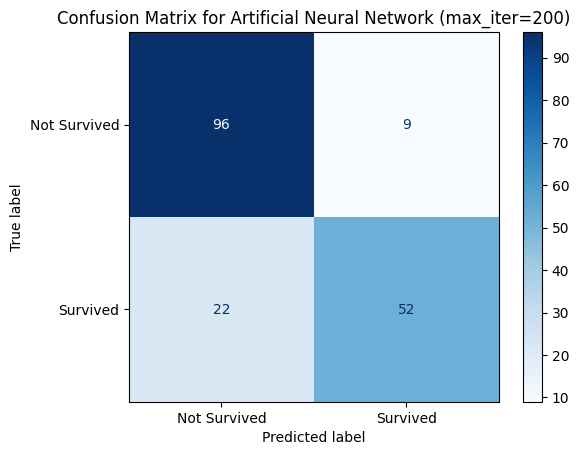

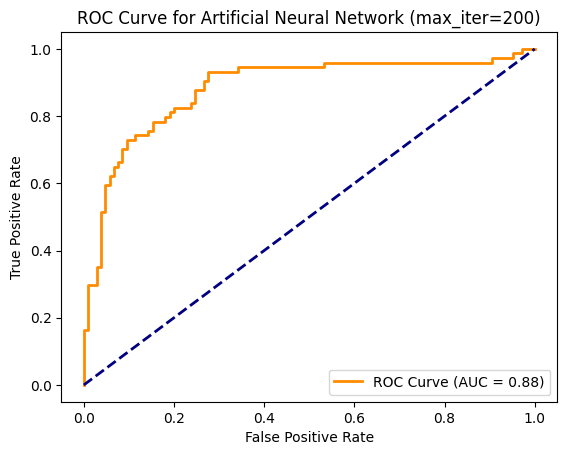

In [8]:
# Artificial Neural Network (max_iter=200)
ann_model = MLPClassifier(random_state=42, max_iter=200)
ann_metrics = train_evaluate_model(
    ann_model, "Artificial Neural Network (max_iter=200)", X_train_scaled, X_test_scaled, y_train, y_test
)
plot_metrics(ann_model, "Artificial Neural Network (max_iter=200)", X_test_scaled, y_test)

Decision Tree (max_depth=5) Training Accuracy: 0.85
Decision Tree (max_depth=5) Testing Accuracy: 0.79

Classification Report for Decision Tree (max_depth=5) on Test Set:
              precision    recall  f1-score   support

           0       0.78      0.90      0.84       105
           1       0.82      0.64      0.72        74

    accuracy                           0.79       179
   macro avg       0.80      0.77      0.78       179
weighted avg       0.80      0.79      0.79       179



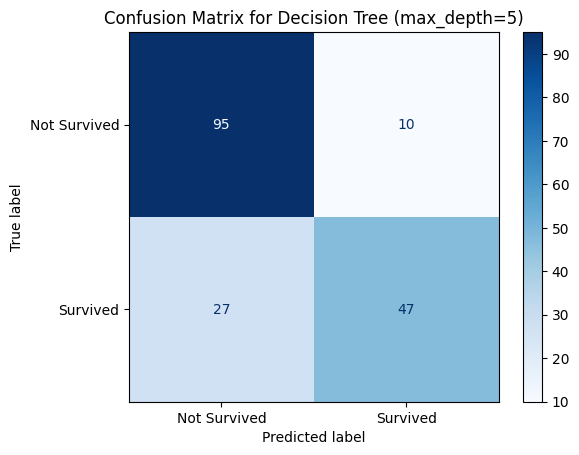

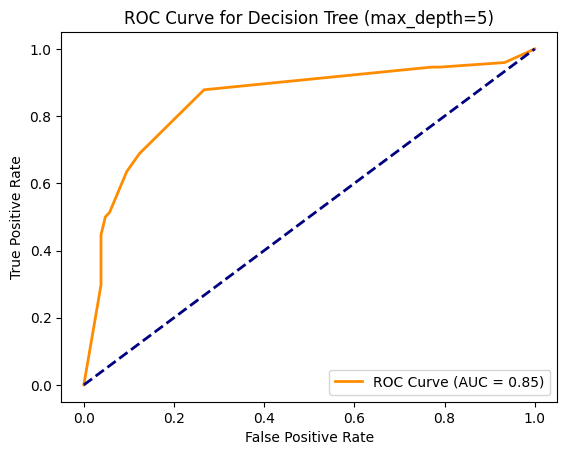

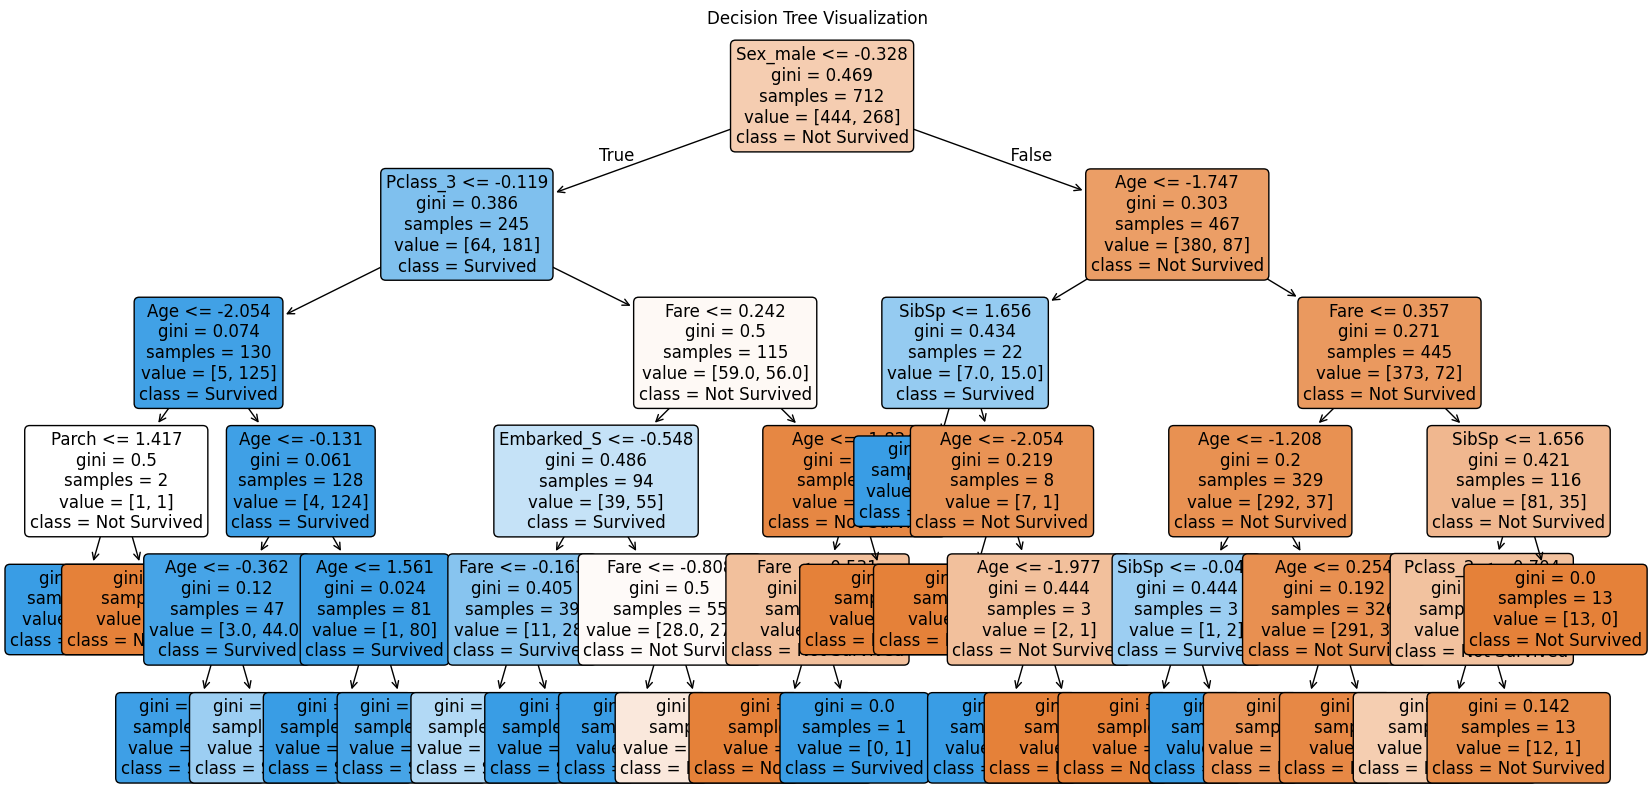

In [9]:
# Decision Tree (max_depth=5)
decision_tree_model = DecisionTreeClassifier(random_state=42, max_depth=5)
decision_tree_metrics = train_evaluate_model(
    decision_tree_model, "Decision Tree (max_depth=5)", X_train_scaled, X_test_scaled, y_train, y_test
)
plot_metrics(decision_tree_model, "Decision Tree (max_depth=5)", X_test_scaled, y_test)

# Plot the Decision Tree
plt.figure(figsize=(20, 10))
plot_tree(
    decision_tree_model,
    feature_names=feature_names,
    class_names=["Not Survived", "Survived"],
    filled=True,
    rounded=True,
    fontsize=12,
)
plt.title("Decision Tree Visualization")
plt.show()

k-NN (k=5) Training Accuracy: 0.86
k-NN (k=5) Testing Accuracy: 0.83

Classification Report for k-NN (k=5) on Test Set:
              precision    recall  f1-score   support

           0       0.84      0.89      0.86       105
           1       0.82      0.76      0.79        74

    accuracy                           0.83       179
   macro avg       0.83      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179



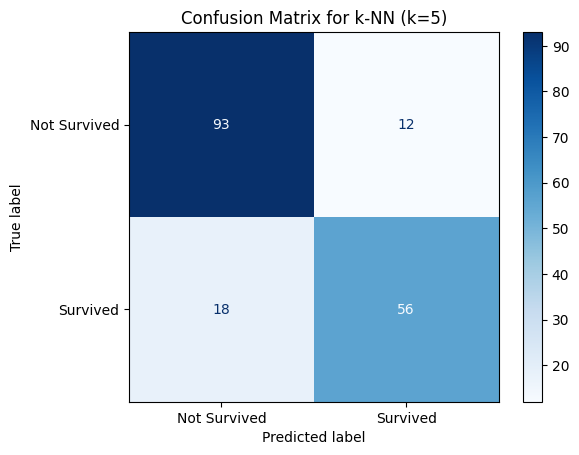

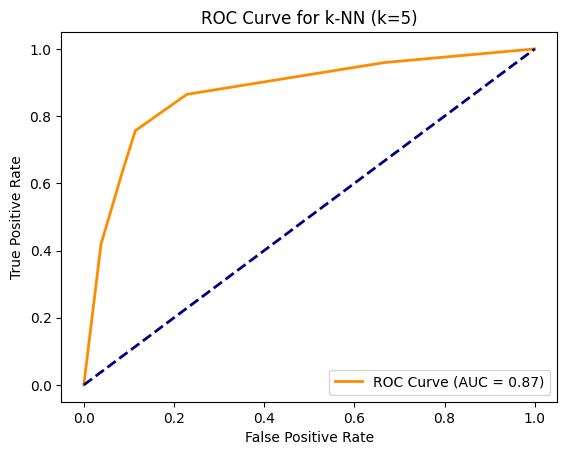

In [10]:
# k-NN (k=5)
k = 5
knn_model = KNeighborsClassifier(n_neighbors=k)
knn_metrics = train_evaluate_model(
    knn_model, f"k-NN (k={k})", X_train_scaled, X_test_scaled, y_train, y_test
)
plot_metrics(knn_model, f"k-NN (k={k})", X_test_scaled, y_test)

Naive Bayes Training Accuracy: 0.78
Naive Bayes Testing Accuracy: 0.77

Classification Report for Naive Bayes on Test Set:
              precision    recall  f1-score   support

           0       0.82      0.76      0.79       105
           1       0.70      0.77      0.73        74

    accuracy                           0.77       179
   macro avg       0.76      0.77      0.76       179
weighted avg       0.77      0.77      0.77       179



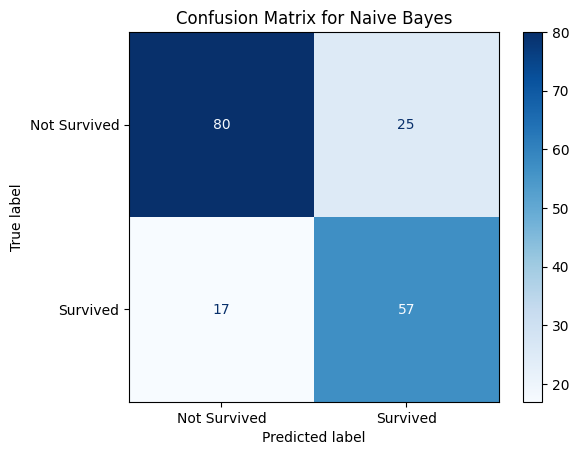

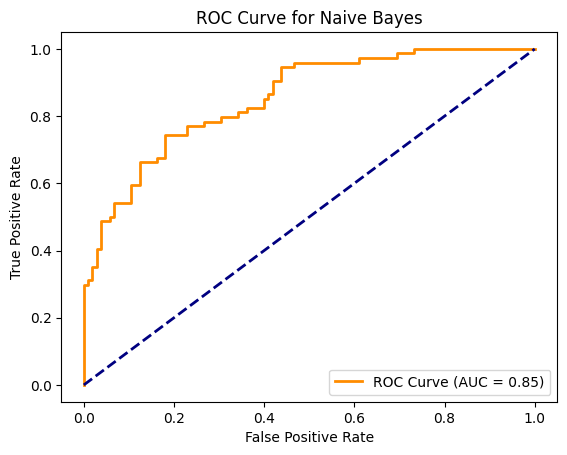

In [11]:
# Naive Bayes
naive_bayes_model = GaussianNB()
naive_bayes_metrics = train_evaluate_model(
    naive_bayes_model, "Naive Bayes", X_train_scaled, X_test_scaled, y_train, y_test
)
plot_metrics(naive_bayes_model, "Naive Bayes", X_test_scaled, y_test)

In [12]:
# Aggregate results into a list
results = [
    baseline_metrics,
    logistic_metrics,
    ann_metrics,
    decision_tree_metrics,
    knn_metrics,
    naive_bayes_metrics,
]

In [13]:
# Create a comparison table
results_df = pd.DataFrame(results)
print("\nComparison Table:")
print(results_df)


Comparison Table:
                                      Model  Test Accuracy  \
0                  Baseline (Most Frequent)       0.586592   
1          Logistic Regression (lambda=1.0)       0.798883   
2  Artificial Neural Network (max_iter=200)       0.826816   
3               Decision Tree (max_depth=5)       0.793296   
4                                k-NN (k=5)       0.832402   
5                               Naive Bayes       0.765363   

   Precision (Survived)  Recall (Survived)  F1-Score (Survived)   ROC-AUC  
0              0.000000           0.000000             0.000000  0.500000  
1              0.779412           0.716216             0.746479  0.882883  
2              0.852459           0.702703             0.770370  0.883398  
3              0.824561           0.635135             0.717557  0.847619  
4              0.823529           0.756757             0.788732  0.871815  
5              0.695122           0.770270             0.730769  0.854183  


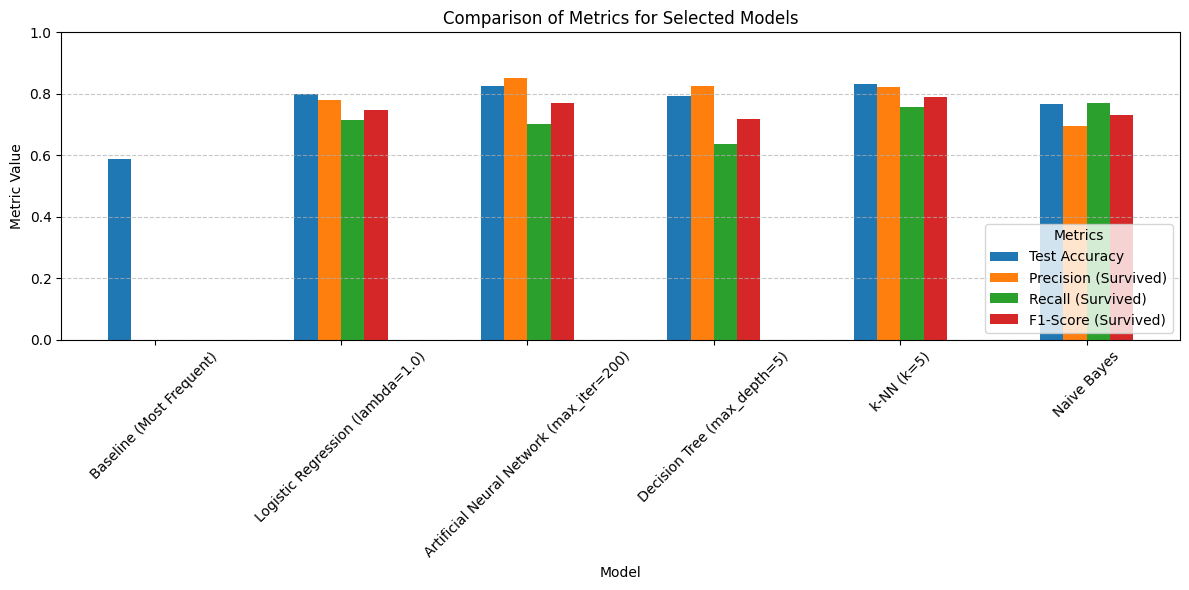

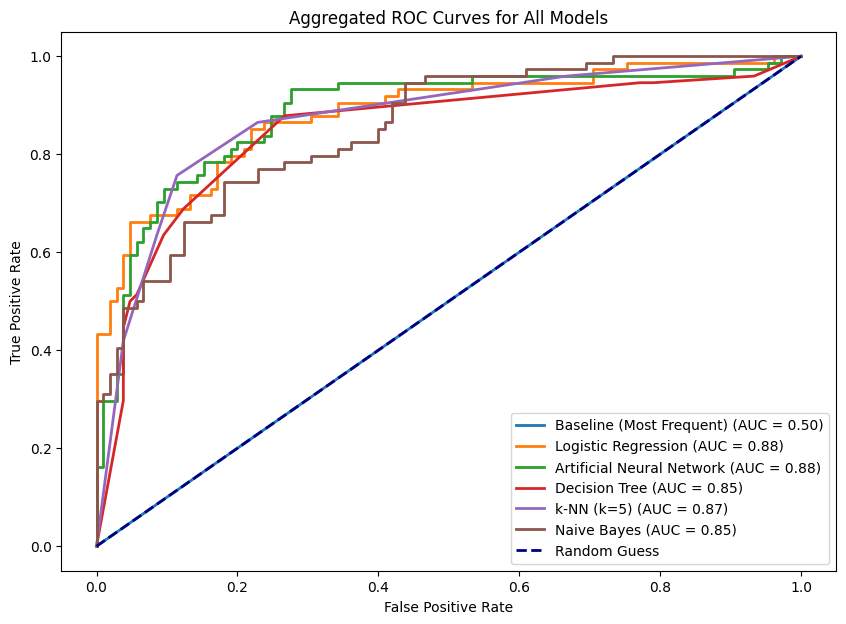

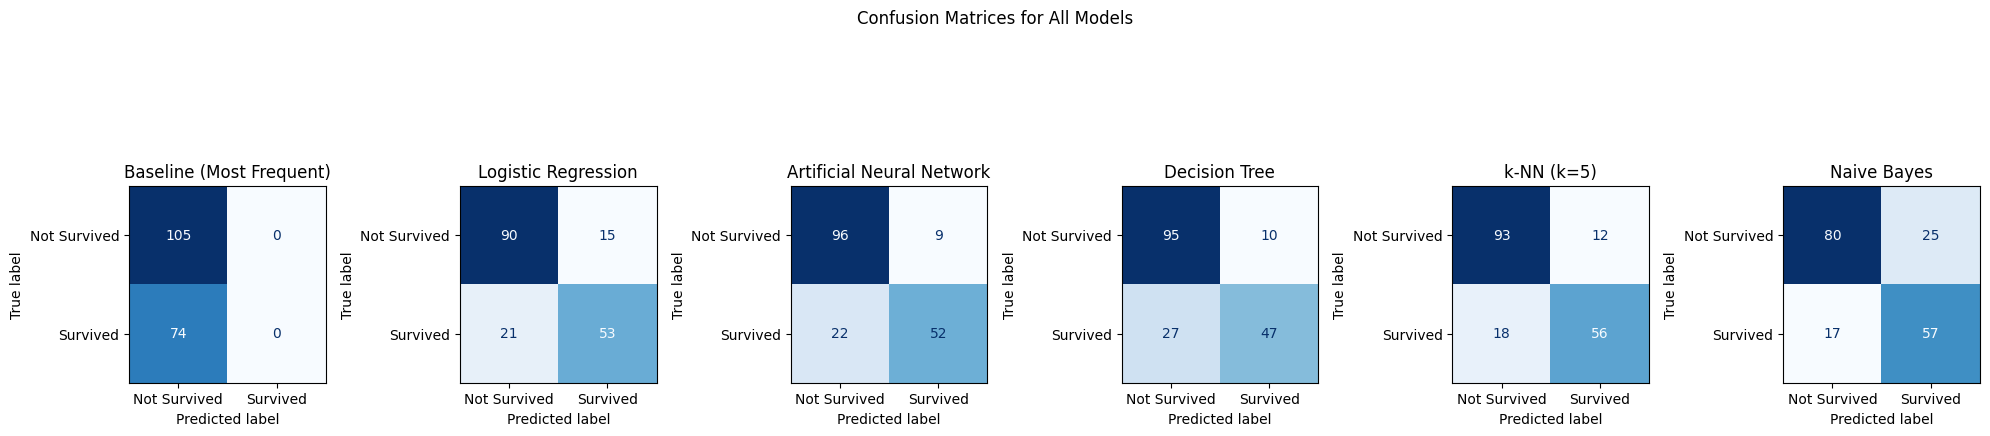

In [14]:
# Define all models and their names
models = [
    (baseline_model, "Baseline (Most Frequent)"),
    (logistic_regression_model, "Logistic Regression"),
    (ann_model, "Artificial Neural Network"),
    (decision_tree_model, "Decision Tree"),
    (knn_model, f"k-NN (k={k})"),
    (naive_bayes_model, "Naive Bayes"),
]

# Select the relevant metrics from the results DataFrame
selected_metrics_df = results_df.set_index("Model")[[
    "Test Accuracy", "Precision (Survived)", "Recall (Survived)", "F1-Score (Survived)"
]]

# Plot aggregated metrics
selected_metrics_df.plot.bar(figsize=(12, 6))
plt.title("Comparison of Metrics for Selected Models")
plt.ylabel("Metric Value")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.ylim(0, 1)  # Ensures all metrics are on the same scale
plt.legend(loc="lower right", title="Metrics")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plot all ROC curves
plt.figure(figsize=(10, 7))
for model, model_name in models:
    if hasattr(model, "predict_proba"):
        y_prob_test = model.predict_proba(X_test_scaled)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob_test)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f"{model_name} (AUC = {roc_auc:.2f})")

# Add diagonal line and labels
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Aggregated ROC Curves for All Models")
plt.legend(loc="lower right")
plt.show()

# Plot confusion matrices
fig, axes = plt.subplots(1, len(models), figsize=(20, 5))
for idx, (model, model_name) in enumerate(models):
    y_pred_test = model.predict(X_test_scaled)
    conf_matrix = confusion_matrix(y_test, y_pred_test)
    ax = axes[idx]
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Not Survived", "Survived"])
    disp.plot(cmap="Blues", ax=ax, colorbar=False)
    ax.set_title(model_name)

# Adjust layout
plt.tight_layout()
plt.suptitle("Confusion Matrices for All Models", y=1.05)
plt.show()

In [15]:
# Define the number of outer folds
outer_folds = 10
kf_outer = KFold(n_splits=outer_folds, shuffle=True, random_state=42)

# Define a range of lambda values to test
lambdas = [0.01, 0.1, 1, 10]  # For logistic regression (C = 1/lambda)

# Define hyperparameters for ANN and Decision Tree
hidden_layer_sizes = [(10,), (50,), (100,)]  # Number of neurons in hidden layers for ANN
max_depths = [3, 5, 10]  # Maximum depth for Decision Tree

# Initialize results
results_table = []

# Outer Loop: For each fold in outer cross-validation
for i, (train_index_outer, test_index_outer) in enumerate(kf_outer.split(X_train_scaled)):
    # Split data into outer training and testing sets
    X_train_outer, X_test_outer = X_train_scaled[train_index_outer], X_train_scaled[test_index_outer]
    y_train_outer, y_test_outer = y_train.iloc[train_index_outer], y_train.iloc[test_index_outer]

    # 1. Baseline
    baseline_model = DummyClassifier(strategy="most_frequent")
    baseline_model.fit(X_train_outer, y_train_outer)
    baseline_predictions = baseline_model.predict(X_test_outer)
    baseline_error = 1 - accuracy_score(y_test_outer, baseline_predictions)

    # 2. Logistic Regression (Inner Cross-Validation for Lambda)
    best_lambda_CV = None
    best_log_reg_error = float("inf")
    kf_inner = KFold(n_splits=5, shuffle=True, random_state=42)  # Inner folds for hyperparameter tuning

    for lambda_value in lambdas:
        inner_errors = []
        for train_index_inner, val_index_inner in kf_inner.split(X_train_outer):
            X_train_inner, X_val_inner = X_train_outer[train_index_inner], X_train_outer[val_index_inner]
            y_train_inner, y_val_inner = y_train_outer.iloc[train_index_inner], y_train_outer.iloc[val_index_inner]

            # Train logistic regression on inner training set
            log_reg_model = LogisticRegression(C=1/lambda_value, random_state=42, max_iter=1000)
            log_reg_model.fit(X_train_inner, y_train_inner)
            val_predictions = log_reg_model.predict(X_val_inner)
            inner_error = 1 - accuracy_score(y_val_inner, val_predictions)
            inner_errors.append(inner_error)

        # Calculate mean error for this lambda
        mean_inner_error = np.mean(inner_errors)
        if mean_inner_error < best_log_reg_error:
            best_log_reg_error = mean_inner_error
            best_lambda_CV = lambda_value

    # Train logistic regression on outer training set with best lambda
    log_reg_model = LogisticRegression(C=1/best_lambda_CV, random_state=42, max_iter=1000)
    log_reg_model.fit(X_train_outer, y_train_outer)
    log_reg_predictions = log_reg_model.predict(X_test_outer)
    log_reg_error = 1 - accuracy_score(y_test_outer, log_reg_predictions)

    # 3. ANN (Inner Cross-Validation for Hidden Layer Sizes)
    best_hidden_layer_CV = None
    best_ann_error = float("inf")

    for hidden_layer in hidden_layer_sizes:
        inner_errors = []
        for train_index_inner, val_index_inner in kf_inner.split(X_train_outer):
            X_train_inner, X_val_inner = X_train_outer[train_index_inner], X_train_outer[val_index_inner]
            y_train_inner, y_val_inner = y_train_outer.iloc[train_index_inner], y_train_outer.iloc[val_index_inner]

            # Train ANN on inner training set
            ann_model = MLPClassifier(hidden_layer_sizes=hidden_layer, random_state=42, max_iter=1000)
            ann_model.fit(X_train_inner, y_train_inner)
            val_predictions = ann_model.predict(X_val_inner)
            inner_error = 1 - accuracy_score(y_val_inner, val_predictions)
            inner_errors.append(inner_error)

        # Calculate mean error for this hidden layer size
        mean_inner_error = np.mean(inner_errors)
        if mean_inner_error < best_ann_error:
            best_ann_error = mean_inner_error
            best_hidden_layer_CV = hidden_layer

    # Train ANN on outer training set with best hidden layer size
    ann_model = MLPClassifier(hidden_layer_sizes=best_hidden_layer_CV, random_state=42, max_iter=1000)
    ann_model.fit(X_train_outer, y_train_outer)
    ann_predictions = ann_model.predict(X_test_outer)
    ann_error = 1 - accuracy_score(y_test_outer, ann_predictions)

    # 4. Decision Tree (Inner Cross-Validation for Max Depth)
    best_depth_CV = None
    best_dt_error = float("inf")

    for depth in max_depths:
        inner_errors = []
        for train_index_inner, val_index_inner in kf_inner.split(X_train_outer):
            X_train_inner, X_val_inner = X_train_outer[train_index_inner], X_train_outer[val_index_inner]
            y_train_inner, y_val_inner = y_train_outer.iloc[train_index_inner], y_train_outer.iloc[val_index_inner]

            # Train Decision Tree on inner training set
            dt_model = DecisionTreeClassifier(max_depth=depth, random_state=42)
            dt_model.fit(X_train_inner, y_train_inner)
            val_predictions = dt_model.predict(X_val_inner)
            inner_error = 1 - accuracy_score(y_val_inner, val_predictions)
            inner_errors.append(inner_error)

        # Calculate mean error for this max depth
        mean_inner_error = np.mean(inner_errors)
        if mean_inner_error < best_dt_error:
            best_dt_error = mean_inner_error
            best_depth_CV = depth

    # Train Decision Tree on outer training set with best max depth
    dt_model = DecisionTreeClassifier(max_depth=best_depth_CV, random_state=42)
    dt_model.fit(X_train_outer, y_train_outer)
    dt_predictions = dt_model.predict(X_test_outer)
    dt_error = 1 - accuracy_score(y_test_outer, dt_predictions)

    # 5. k-NN (Inner Cross-Validation for k)
    best_k_CV = None
    best_knn_error = float("inf")

    for k in range(1, 21):
        inner_errors = []
        for train_index_inner, val_index_inner in kf_inner.split(X_train_outer):
            X_train_inner, X_val_inner = X_train_outer[train_index_inner], X_train_outer[val_index_inner]
            y_train_inner, y_val_inner = y_train_outer.iloc[train_index_inner], y_train_outer.iloc[val_index_inner]

            # Train k-NN on inner training set
            knn_model = KNeighborsClassifier(n_neighbors=k)
            knn_model.fit(X_train_inner, y_train_inner)
            val_predictions = knn_model.predict(X_val_inner)
            inner_error = 1 - accuracy_score(y_val_inner, val_predictions)
            inner_errors.append(inner_error)

        # Calculate mean error for this k
        mean_inner_error = np.mean(inner_errors)
        if mean_inner_error < best_knn_error:
            best_knn_error = mean_inner_error
            best_k_CV = k

    # Train k-NN on outer training set with best k
    knn_model = KNeighborsClassifier(n_neighbors=best_k_CV)
    knn_model.fit(X_train_outer, y_train_outer)
    knn_predictions = knn_model.predict(X_test_outer)
    knn_error = 1 - accuracy_score(y_test_outer, knn_predictions)

    # 6. Naive Bayes
    nb_model = GaussianNB()
    nb_model.fit(X_train_outer, y_train_outer)
    nb_predictions = nb_model.predict(X_test_outer)
    nb_error = 1 - accuracy_score(y_test_outer, nb_predictions)

    # Append results for this fold
    results_table.append({
        "Outer Fold": i + 1,
        "Logistic Regression (lambda*)": best_lambda_CV,
        "Logistic Regression Error (E_test)": log_reg_error * 100,
        "ANN (hidden_layer*)": best_hidden_layer_CV,
        "ANN Error (E_test)": ann_error * 100,
        "Decision Tree (max_depth*)": best_depth_CV,
        "Decision Tree Error (E_test)": dt_error * 100,
        "k-NN (k*)": best_k_CV,
        "k-NN Error (E_test)": knn_error * 100,
        "Naive Bayes Error (E_test)": nb_error * 100,
        "Baseline Error (E_test)": baseline_error * 100
    })

/Users/ignacioripollgonzalez/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ignacioripollgonzalez/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ignacioripollgonzalez/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ignacioripollgonzalez/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the 

In [16]:
# Create table from cross-validation results
table_data = []
for fold in results_table:
    table_data.append({
        "Outer Fold": fold["Outer Fold"],
        "Logistic Regression (λ*)": fold["Logistic Regression (lambda*)"],
        "Logistic Regression (E_test)": fold["Logistic Regression Error (E_test)"],
        "ANN (hidden_layer*)": fold["ANN (hidden_layer*)"],
        "ANN (E_test)": fold["ANN Error (E_test)"],
        "Decision Tree (max_depth*)": fold["Decision Tree (max_depth*)"],
        "Decision Tree (E_test)": fold["Decision Tree Error (E_test)"],
        "k-NN (k*)": fold["k-NN (k*)"],
        "k-NN (E_test)": fold["k-NN Error (E_test)"],
        "Naive Bayes (E_test)": fold["Naive Bayes Error (E_test)"],
        "Baseline (E_test)": fold["Baseline Error (E_test)"],
    })

# Convert to DataFrame
results_df = pd.DataFrame(table_data)

# Display the table
print("\nTwo-level Cross-Validation Table:")
print(results_df)


Two-level Cross-Validation Table:
   Outer Fold  Logistic Regression (λ*)  Logistic Regression (E_test)  \
0           1                        10                     15.277778   
1           2                        10                     22.222222   
2           3                        10                     19.718310   
3           4                        10                     26.760563   
4           5                        10                     22.535211   
5           6                        10                     19.718310   
6           7                        10                     12.676056   
7           8                        10                     18.309859   
8           9                        10                     19.718310   
9          10                         1                     19.718310   

  ANN (hidden_layer*)  ANN (E_test)  Decision Tree (max_depth*)  \
0               (10,)     15.277778                           3   
1               (10,)     2

Logistic Regression (lambda=1) Training Accuracy: 0.81
Logistic Regression (lambda=1) Testing Accuracy: 0.80

Classification Report for Logistic Regression (lambda=1) on Test Set:
              precision    recall  f1-score   support

           0       0.81      0.86      0.83       105
           1       0.78      0.72      0.75        74

    accuracy                           0.80       179
   macro avg       0.80      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179



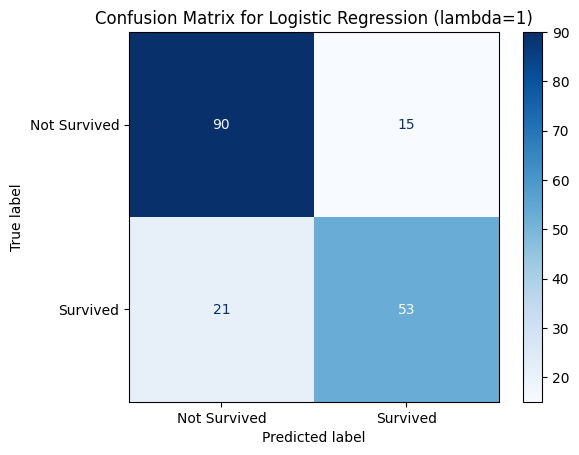

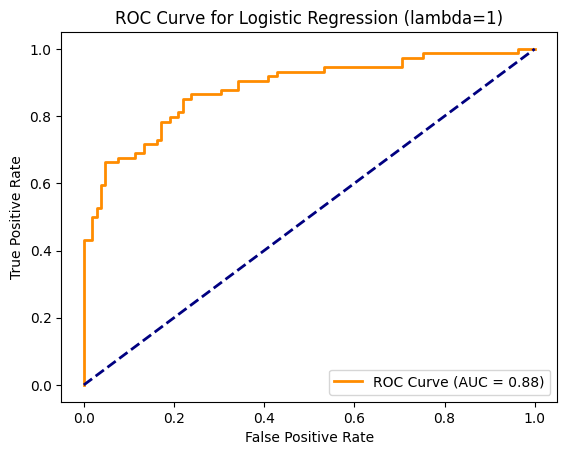

In [17]:
# Logistic Regression (lambda=best_lambda_CV)
logistic_regression_model_CV = LogisticRegression(C=1/best_lambda_CV, random_state=42, max_iter=1000)
logistic_metrics_CV = train_evaluate_model(
    logistic_regression_model_CV, f"Logistic Regression (lambda={best_lambda_CV})", X_train_scaled, X_test_scaled, y_train, y_test
)
plot_metrics(logistic_regression_model_CV, f"Logistic Regression (lambda={best_lambda_CV})", X_test_scaled, y_test)


Feature Importance (Logistic Regression_CV):
      Feature  Coefficient  Abs_Coefficient
4    Sex_male    -1.256654         1.256654
8    Pclass_3    -0.681485         0.681485
1       SibSp    -0.438569         0.438569
3        Fare     0.397122         0.397122
0         Age    -0.385737         0.385737
6  Embarked_S    -0.190250         0.190250
2       Parch    -0.159312         0.159312
7    Pclass_2    -0.108856         0.108856
5  Embarked_Q    -0.026999         0.026999


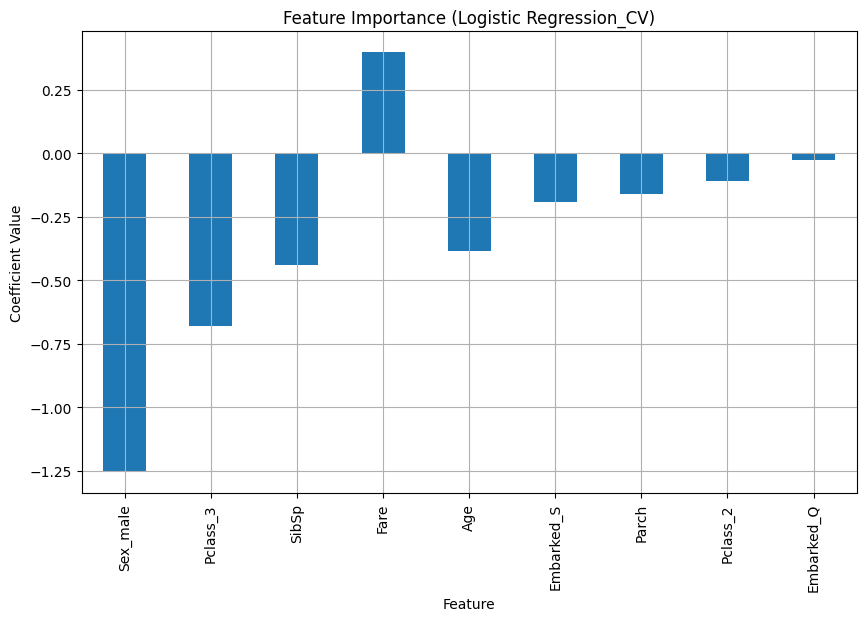

In [18]:
# Train Logistic Regression with the best lambda
logistic_regression_model_CV = LogisticRegression(C=1/best_lambda_CV, random_state=42, max_iter=1000)
logistic_regression_model_CV.fit(X_train_scaled, y_train)

# Extract coefficients and feature importance
coefficients = logistic_regression_model_CV.coef_.flatten()

# Check lengths to ensure alignment
if len(feature_names) != len(coefficients):
    raise ValueError("Feature names and coefficients length mismatch!")

# Create a DataFrame to analyze feature importance
coefficients_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefficients,
    "Abs_Coefficient": np.abs(coefficients)  # Absolute value for ranking
}).sort_values(by="Abs_Coefficient", ascending=False)

# Display the coefficients
print("\nFeature Importance (Logistic Regression_CV):")
print(coefficients_df)

# Optional: Plot feature importance
coefficients_df.plot(kind="bar", x="Feature", y="Coefficient", legend=False, figsize=(10, 6))
plt.title("Feature Importance (Logistic Regression_CV)")
plt.ylabel("Coefficient Value")
plt.xlabel("Feature")
plt.grid()
plt.show()


Comparison Table:
                    Model  Test Accuracy  Precision (Survived)  \
0     Logistic Regression       0.798883              0.779412   
1  Logistic Regression_CV       0.798883              0.779412   

   Recall (Survived)  F1-Score (Survived)   ROC-AUC  
0           0.716216             0.746479  0.882883  
1           0.716216             0.746479  0.882883  


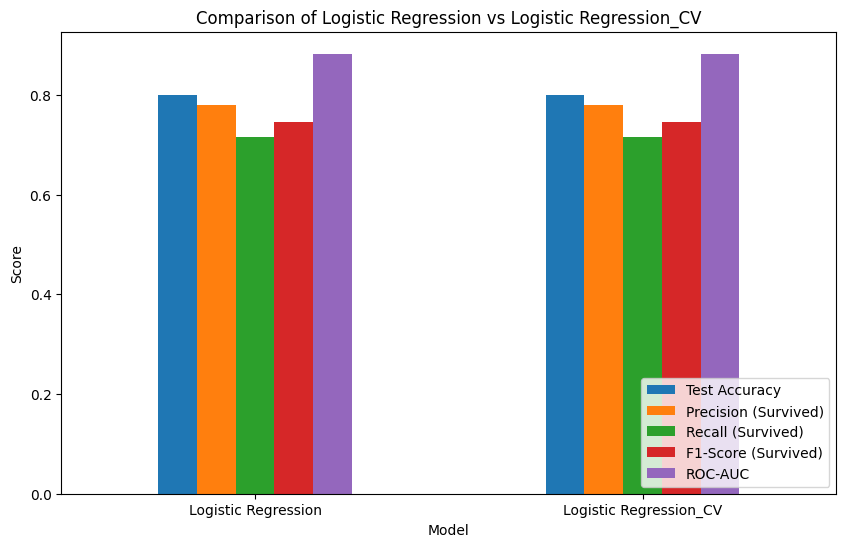

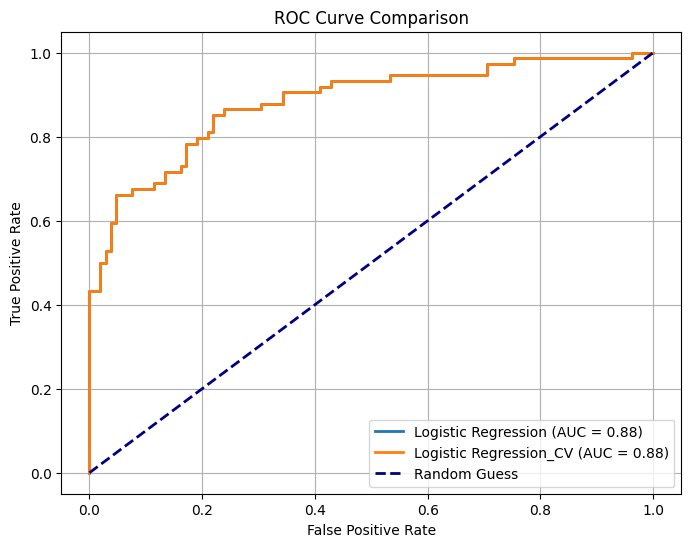

In [19]:
# Create a comparison table for Logistic Regression
comparison_data = {
    "Model": ["Logistic Regression", "Logistic Regression_CV"],
    "Test Accuracy": [
        logistic_metrics["Test Accuracy"],
        logistic_metrics_CV["Test Accuracy"]
    ],
    "Precision (Survived)": [
        logistic_metrics["Precision (Survived)"],
        logistic_metrics_CV["Precision (Survived)"]
    ],
    "Recall (Survived)": [
        logistic_metrics["Recall (Survived)"],
        logistic_metrics_CV["Recall (Survived)"]
    ],
    "F1-Score (Survived)": [
        logistic_metrics["F1-Score (Survived)"],
        logistic_metrics_CV["F1-Score (Survived)"]
    ],
    "ROC-AUC": [
        logistic_metrics["ROC-AUC"],
        logistic_metrics_CV["ROC-AUC"]
    ]
}

# Convert to DataFrame
comparison_df = pd.DataFrame(comparison_data)

# Display the table
print("\nComparison Table:")
print(comparison_df)

# Bar plot for accuracy, precision, recall, F1-score, and ROC-AUC
metrics = ["Test Accuracy", "Precision (Survived)", "Recall (Survived)", "F1-Score (Survived)", "ROC-AUC"]
comparison_df.set_index("Model")[metrics].plot(kind="bar", figsize=(10, 6))
plt.title("Comparison of Logistic Regression vs Logistic Regression_CV")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.legend(loc="lower right")
plt.show()

# Plot ROC curves for both models
plt.figure(figsize=(8, 6))

# Logistic Regression
if hasattr(logistic_regression_model, "predict_proba"):
    y_prob_lr = logistic_regression_model.predict_proba(X_test_scaled)[:, 1]
    fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
    roc_auc_lr = auc(fpr_lr, tpr_lr)
    plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {roc_auc_lr:.2f})", lw=2)

# Logistic Regression_CV
if hasattr(logistic_regression_model_CV, "predict_proba"):
    y_prob_lr_cv = logistic_regression_model_CV.predict_proba(X_test_scaled)[:, 1]
    fpr_lr_cv, tpr_lr_cv, _ = roc_curve(y_test, y_prob_lr_cv)
    roc_auc_lr_cv = auc(fpr_lr_cv, tpr_lr_cv)
    plt.plot(fpr_lr_cv, tpr_lr_cv, label=f"Logistic Regression_CV (AUC = {roc_auc_lr_cv:.2f})", lw=2)

# Plot random guess line
plt.plot([0, 1], [0, 1], color="navy", linestyle="--", lw=2, label="Random Guess")

# Graph details
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

Artificial Neural Network (hidden_layer=(50,), max_iter=200) Training Accuracy: 0.85
Artificial Neural Network (hidden_layer=(50,), max_iter=200) Testing Accuracy: 0.82

Classification Report for Artificial Neural Network (hidden_layer=(50,), max_iter=200) on Test Set:
              precision    recall  f1-score   support

           0       0.81      0.90      0.85       105
           1       0.84      0.69      0.76        74

    accuracy                           0.82       179
   macro avg       0.82      0.80      0.80       179
weighted avg       0.82      0.82      0.81       179



/Users/ignacioripollgonzalez/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


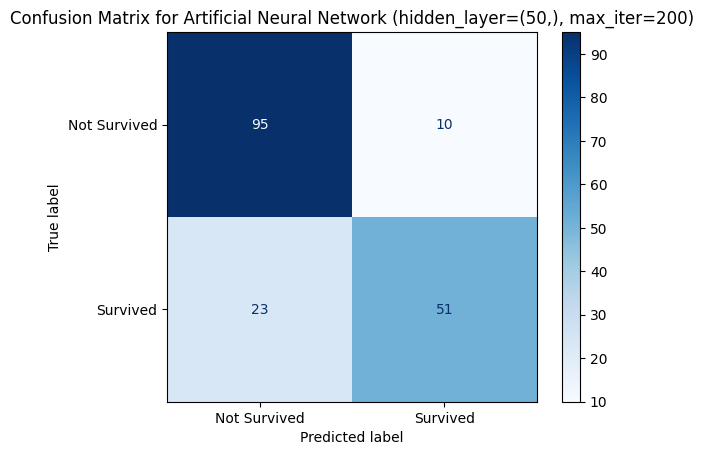

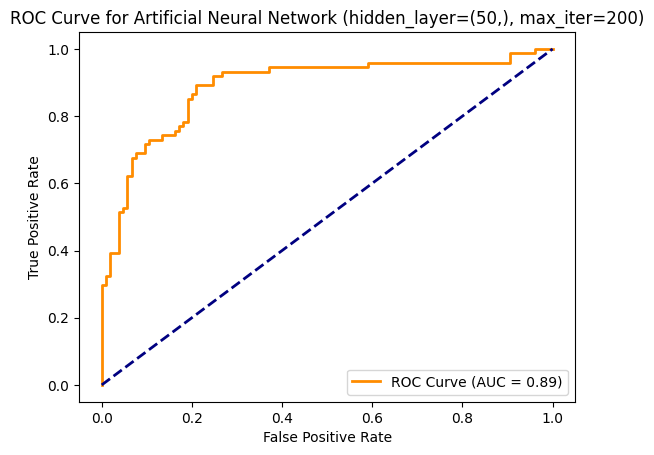

In [20]:
# Artificial Neural Network (hidden_layer=best_hidden_layer_CV, max_iter=200)
ann_model_CV = MLPClassifier(hidden_layer_sizes=best_hidden_layer_CV, random_state=42, max_iter=200)
ann_metrics_CV = train_evaluate_model(
    ann_model_CV, f"Artificial Neural Network (hidden_layer={best_hidden_layer_CV}, max_iter=200)", 
    X_train_scaled, X_test_scaled, y_train, y_test
)
plot_metrics(ann_model_CV, f"Artificial Neural Network (hidden_layer={best_hidden_layer_CV}, max_iter=200)", X_test_scaled, y_test)


Comparison Table for ANN:
    Model  Test Accuracy  Precision (Survived)  Recall (Survived)  \
0     ANN       0.826816              0.852459           0.702703   
1  ANN_CV       0.815642              0.836066           0.689189   

   F1-Score (Survived)   ROC-AUC  
0             0.770370  0.883398  
1             0.755556  0.888417  


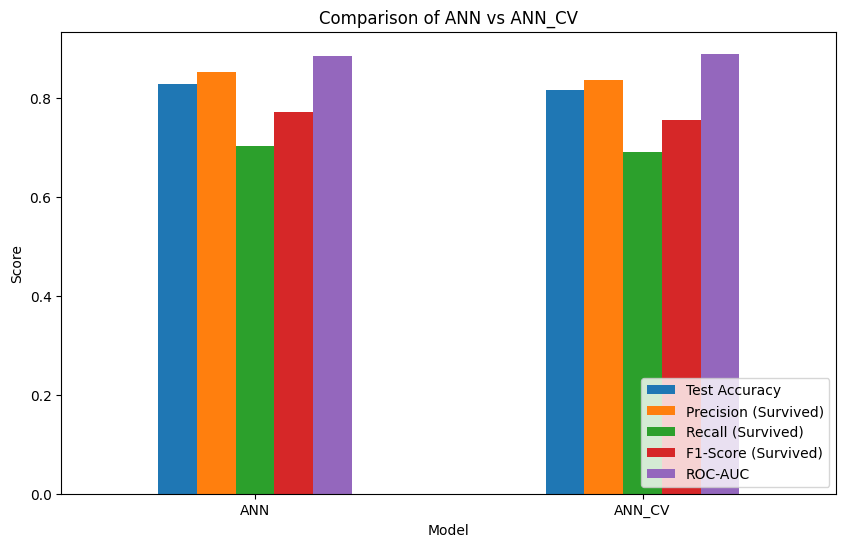

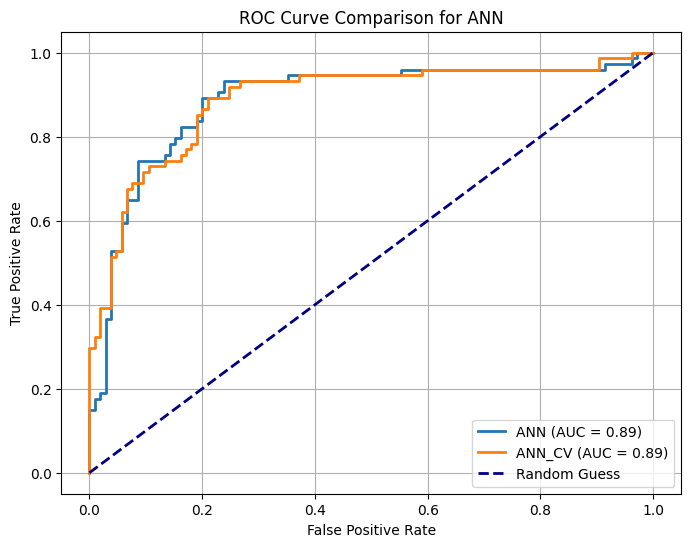

In [21]:
# Create a comparison table for ANN
comparison_data_ann = {
    "Model": ["ANN", "ANN_CV"],
    "Test Accuracy": [
        ann_metrics["Test Accuracy"],
        ann_metrics_CV["Test Accuracy"]
    ],
    "Precision (Survived)": [
        ann_metrics["Precision (Survived)"],
        ann_metrics_CV["Precision (Survived)"]
    ],
    "Recall (Survived)": [
        ann_metrics["Recall (Survived)"],
        ann_metrics_CV["Recall (Survived)"]
    ],
    "F1-Score (Survived)": [
        ann_metrics["F1-Score (Survived)"],
        ann_metrics_CV["F1-Score (Survived)"]
    ],
    "ROC-AUC": [
        ann_metrics["ROC-AUC"],
        ann_metrics_CV["ROC-AUC"]
    ]
}

# Convert to DataFrame
comparison_df_ann = pd.DataFrame(comparison_data_ann)

# Display the table
print("\nComparison Table for ANN:")
print(comparison_df_ann)

# Bar plot for accuracy, precision, recall, F1-score, and ROC-AUC
metrics = ["Test Accuracy", "Precision (Survived)", "Recall (Survived)", "F1-Score (Survived)", "ROC-AUC"]
comparison_df_ann.set_index("Model")[metrics].plot(kind="bar", figsize=(10, 6))
plt.title("Comparison of ANN vs ANN_CV")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.legend(loc="lower right")
plt.show()

# Plot ROC curves for both models
plt.figure(figsize=(8, 6))

# ANN
if hasattr(ann_model, "predict_proba"):
    y_prob_ann = ann_model.predict_proba(X_test_scaled)[:, 1]
    fpr_ann, tpr_ann, _ = roc_curve(y_test, y_prob_ann)
    roc_auc_ann = auc(fpr_ann, tpr_ann)
    plt.plot(fpr_ann, tpr_ann, label=f"ANN (AUC = {roc_auc_ann:.2f})", lw=2)

# ANN_CV
if hasattr(ann_model_CV, "predict_proba"):
    y_prob_ann_cv = ann_model_CV.predict_proba(X_test_scaled)[:, 1]
    fpr_ann_cv, tpr_ann_cv, _ = roc_curve(y_test, y_prob_ann_cv)
    roc_auc_ann_cv = auc(fpr_ann_cv, tpr_ann_cv)
    plt.plot(fpr_ann_cv, tpr_ann_cv, label=f"ANN_CV (AUC = {roc_auc_ann_cv:.2f})", lw=2)

# Plot random guess line
plt.plot([0, 1], [0, 1], color="navy", linestyle="--", lw=2, label="Random Guess")

# Graph details
plt.title("ROC Curve Comparison for ANN")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

Decision Tree (max_depth=3) Training Accuracy: 0.83
Decision Tree (max_depth=3) Testing Accuracy: 0.80

Classification Report for Decision Tree (max_depth=3) on Test Set:
              precision    recall  f1-score   support

           0       0.80      0.88      0.84       105
           1       0.80      0.69      0.74        74

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179



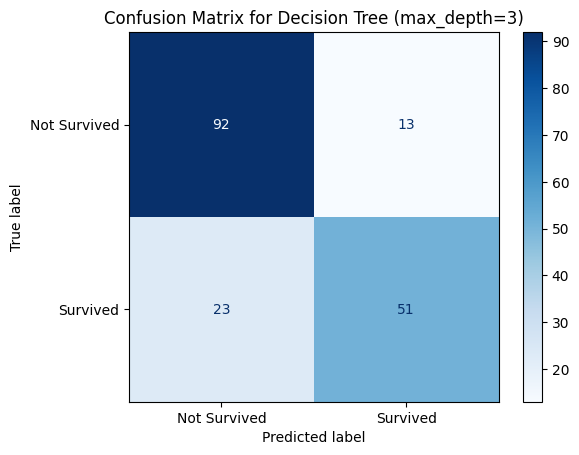

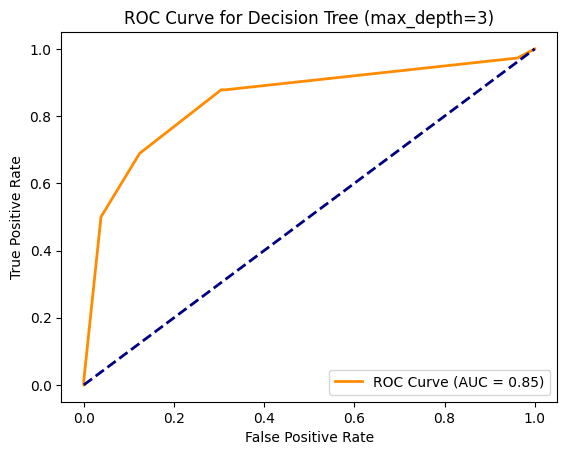

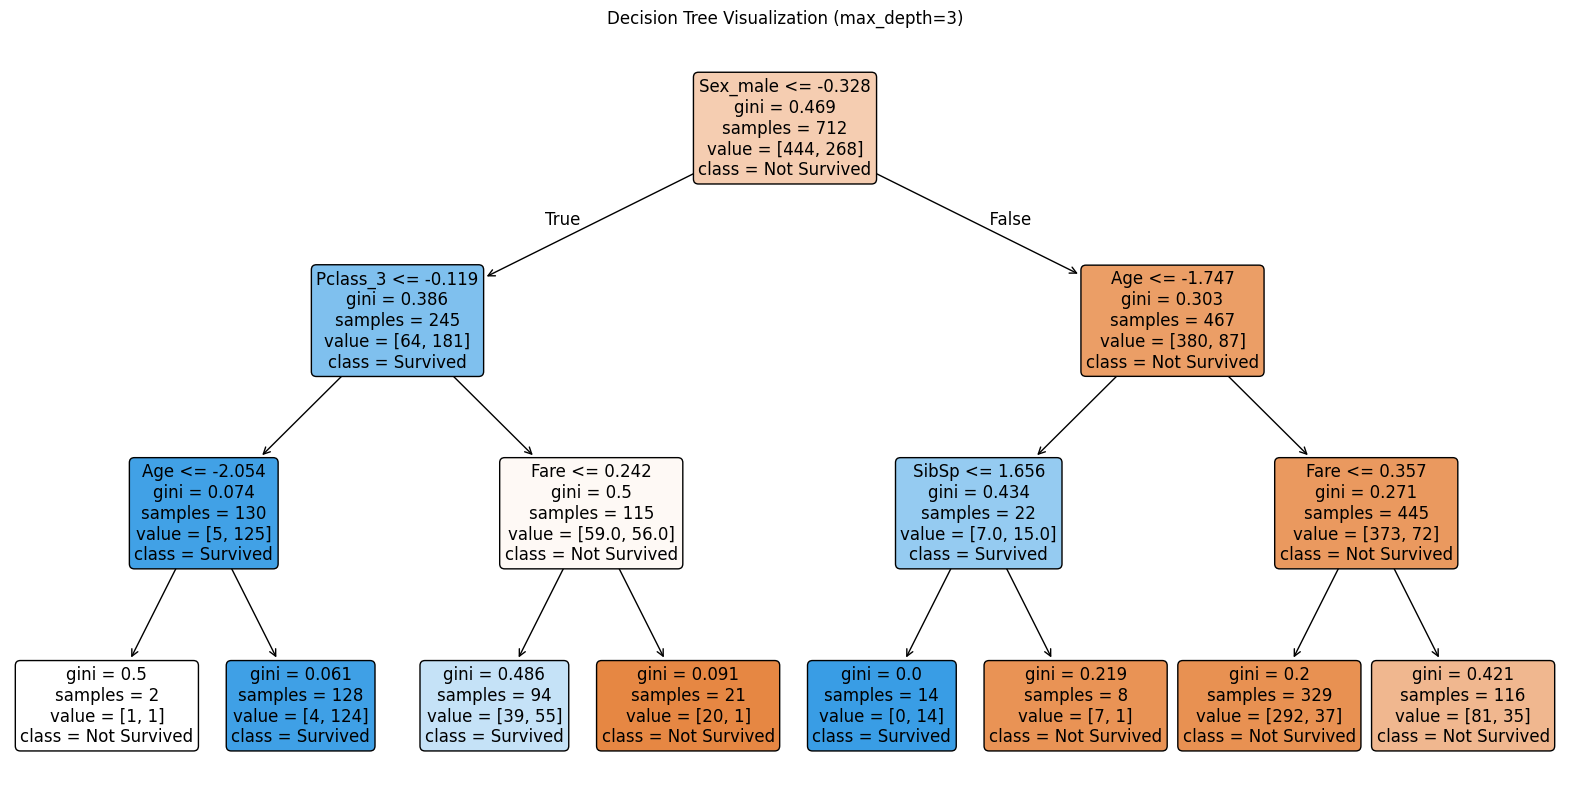

In [22]:
# Decision Tree (max_depth=best_depth_CV)
decision_tree_model_CV = DecisionTreeClassifier(random_state=42, max_depth=best_depth_CV)
decision_tree_metrics_CV = train_evaluate_model(
    decision_tree_model_CV, f"Decision Tree (max_depth={best_depth_CV})", X_train_scaled, X_test_scaled, y_train, y_test
)
plot_metrics(decision_tree_model_CV, f"Decision Tree (max_depth={best_depth_CV})", X_test_scaled, y_test)

# Plot the Decision Tree
plt.figure(figsize=(20, 10))
plot_tree(
    decision_tree_model_CV,
    feature_names=feature_names,  # Dynamically retrieved feature names
    class_names=["Not Survived", "Survived"],
    filled=True,
    rounded=True,
    fontsize=12,
)
plt.title(f"Decision Tree Visualization (max_depth={best_depth_CV})")
plt.show()


Comparison Table for Decision Tree:
              Model  Test Accuracy  Precision (Survived)  Recall (Survived)  \
0     Decision Tree       0.793296              0.824561           0.635135   
1  Decision Tree_CV       0.798883              0.796875           0.689189   

   F1-Score (Survived)   ROC-AUC  
0             0.717557  0.847619  
1             0.739130  0.848005  


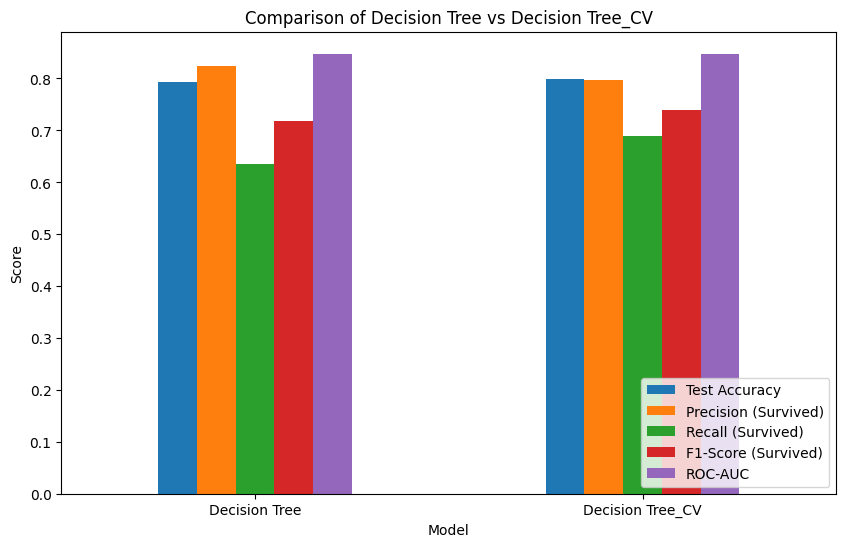

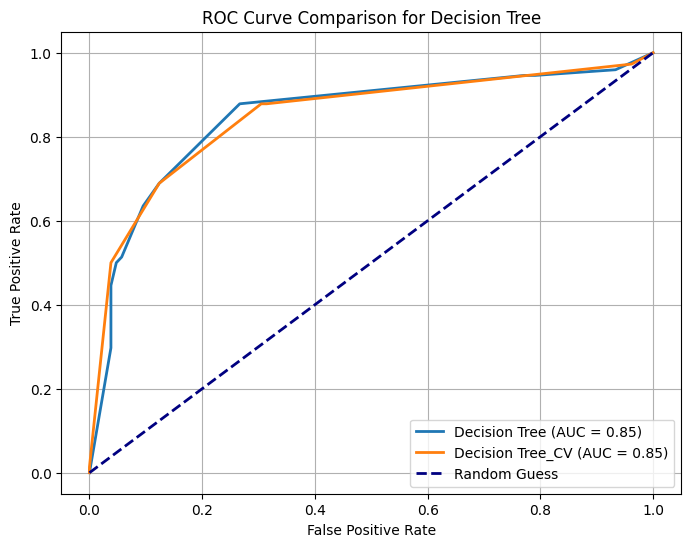

In [23]:
# Create a comparison table for Decision Tree
comparison_data_dt = {
    "Model": ["Decision Tree", "Decision Tree_CV"],
    "Test Accuracy": [
        decision_tree_metrics["Test Accuracy"],
        decision_tree_metrics_CV["Test Accuracy"]
    ],
    "Precision (Survived)": [
        decision_tree_metrics["Precision (Survived)"],
        decision_tree_metrics_CV["Precision (Survived)"]
    ],
    "Recall (Survived)": [
        decision_tree_metrics["Recall (Survived)"],
        decision_tree_metrics_CV["Recall (Survived)"]
    ],
    "F1-Score (Survived)": [
        decision_tree_metrics["F1-Score (Survived)"],
        decision_tree_metrics_CV["F1-Score (Survived)"]
    ],
    "ROC-AUC": [
        decision_tree_metrics["ROC-AUC"],
        decision_tree_metrics_CV["ROC-AUC"]
    ]
}

# Convert to DataFrame
comparison_df_dt = pd.DataFrame(comparison_data_dt)

# Display the table
print("\nComparison Table for Decision Tree:")
print(comparison_df_dt)

# Bar plot for accuracy, precision, recall, F1-score, and ROC-AUC
metrics = ["Test Accuracy", "Precision (Survived)", "Recall (Survived)", "F1-Score (Survived)", "ROC-AUC"]
comparison_df_dt.set_index("Model")[metrics].plot(kind="bar", figsize=(10, 6))
plt.title("Comparison of Decision Tree vs Decision Tree_CV")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.legend(loc="lower right")
plt.show()

# Plot ROC curves for both models
plt.figure(figsize=(8, 6))

# Decision Tree
if hasattr(decision_tree_model, "predict_proba"):
    y_prob_dt = decision_tree_model.predict_proba(X_test_scaled)[:, 1]
    fpr_dt, tpr_dt, _ = roc_curve(y_test, y_prob_dt)
    roc_auc_dt = auc(fpr_dt, tpr_dt)
    plt.plot(fpr_dt, tpr_dt, label=f"Decision Tree (AUC = {roc_auc_dt:.2f})", lw=2)

# Decision Tree_CV
if hasattr(decision_tree_model_CV, "predict_proba"):
    y_prob_dt_cv = decision_tree_model_CV.predict_proba(X_test_scaled)[:, 1]
    fpr_dt_cv, tpr_dt_cv, _ = roc_curve(y_test, y_prob_dt_cv)
    roc_auc_dt_cv = auc(fpr_dt_cv, tpr_dt_cv)
    plt.plot(fpr_dt_cv, tpr_dt_cv, label=f"Decision Tree_CV (AUC = {roc_auc_dt_cv:.2f})", lw=2)

# Plot random guess line
plt.plot([0, 1], [0, 1], color="navy", linestyle="--", lw=2, label="Random Guess")

# Graph details
plt.title("ROC Curve Comparison for Decision Tree")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

k-NN (k=16) Training Accuracy: 0.82
k-NN (k=16) Testing Accuracy: 0.83

Classification Report for k-NN (k=16) on Test Set:
              precision    recall  f1-score   support

           0       0.80      0.93      0.86       105
           1       0.88      0.68      0.76        74

    accuracy                           0.83       179
   macro avg       0.84      0.80      0.81       179
weighted avg       0.83      0.83      0.82       179



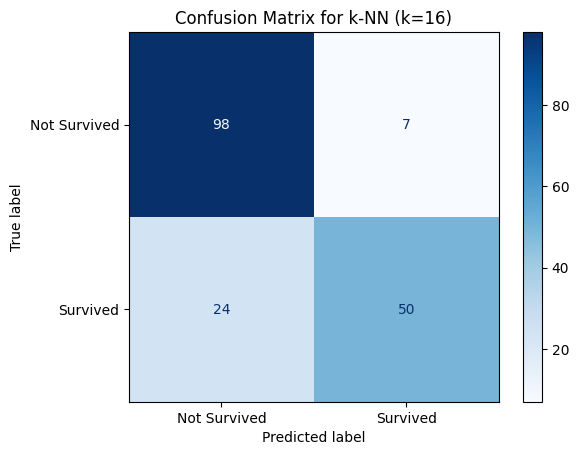

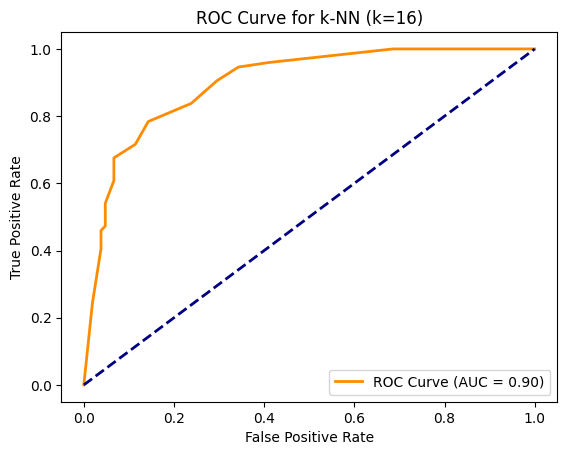

In [24]:
# Train and evaluate k-NN with cross-validated best k
knn_model_CV = KNeighborsClassifier(n_neighbors=best_k_CV)
knn_metrics_CV = train_evaluate_model(
    knn_model_CV, f"k-NN (k={best_k_CV})", X_train_scaled, X_test_scaled, y_train, y_test
)
plot_metrics(knn_model_CV, f"k-NN (k={best_k_CV})", X_test_scaled, y_test)


Comparison Table for k-NN:
     Model  Test Accuracy  Precision (Survived)  Recall (Survived)  \
0     k-NN       0.832402              0.823529           0.756757   
1  k-NN_CV       0.826816              0.877193           0.675676   

   F1-Score (Survived)   ROC-AUC  
0             0.788732  0.871815  
1             0.763359  0.897941  


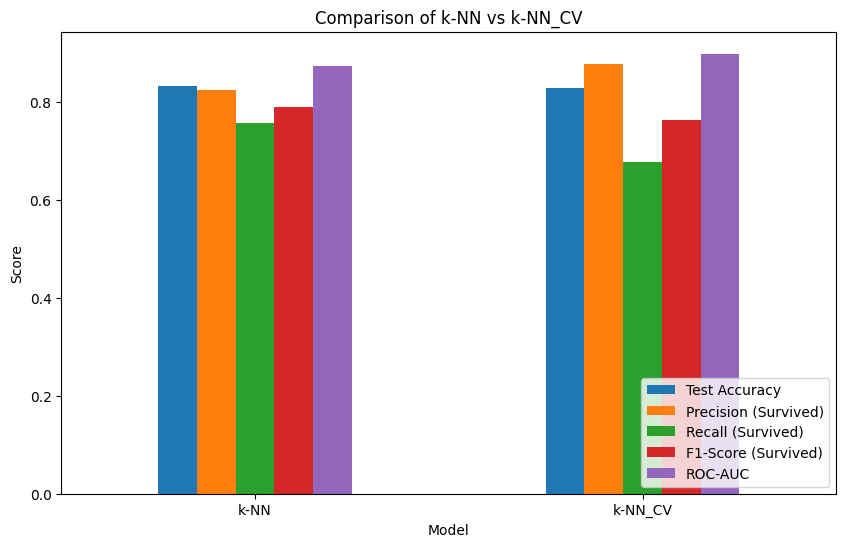

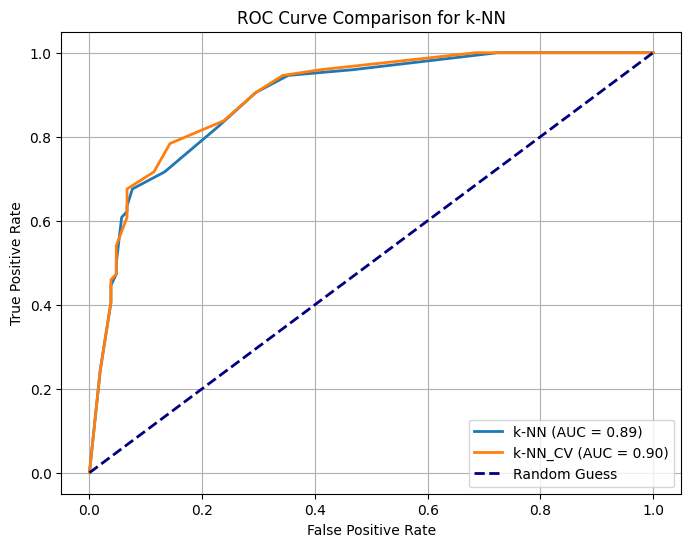

In [25]:
# Create a comparison table for k-NN
comparison_data_knn = {
    "Model": ["k-NN", "k-NN_CV"],
    "Test Accuracy": [
        knn_metrics["Test Accuracy"],
        knn_metrics_CV["Test Accuracy"]
    ],
    "Precision (Survived)": [
        knn_metrics["Precision (Survived)"],
        knn_metrics_CV["Precision (Survived)"]
    ],
    "Recall (Survived)": [
        knn_metrics["Recall (Survived)"],
        knn_metrics_CV["Recall (Survived)"]
    ],
    "F1-Score (Survived)": [
        knn_metrics["F1-Score (Survived)"],
        knn_metrics_CV["F1-Score (Survived)"]
    ],
    "ROC-AUC": [
        knn_metrics["ROC-AUC"],
        knn_metrics_CV["ROC-AUC"]
    ]
}

# Convert to DataFrame
comparison_df_knn = pd.DataFrame(comparison_data_knn)

# Display the table
print("\nComparison Table for k-NN:")
print(comparison_df_knn)

# Bar plot for accuracy, precision, recall, F1-score, and ROC-AUC
metrics = ["Test Accuracy", "Precision (Survived)", "Recall (Survived)", "F1-Score (Survived)", "ROC-AUC"]
comparison_df_knn.set_index("Model")[metrics].plot(kind="bar", figsize=(10, 6))
plt.title("Comparison of k-NN vs k-NN_CV")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.legend(loc="lower right")
plt.show()

# Plot ROC curves for both models
plt.figure(figsize=(8, 6))

# k-NN
if hasattr(knn_model, "predict_proba"):
    y_prob_knn = knn_model.predict_proba(X_test_scaled)[:, 1]
    fpr_knn, tpr_knn, _ = roc_curve(y_test, y_prob_knn)
    roc_auc_knn = auc(fpr_knn, tpr_knn)
    plt.plot(fpr_knn, tpr_knn, label=f"k-NN (AUC = {roc_auc_knn:.2f})", lw=2)

# k-NN_CV
if hasattr(knn_model_CV, "predict_proba"):
    y_prob_knn_cv = knn_model_CV.predict_proba(X_test_scaled)[:, 1]
    fpr_knn_cv, tpr_knn_cv, _ = roc_curve(y_test, y_prob_knn_cv)
    roc_auc_knn_cv = auc(fpr_knn_cv, tpr_knn_cv)
    plt.plot(fpr_knn_cv, tpr_knn_cv, label=f"k-NN_CV (AUC = {roc_auc_knn_cv:.2f})", lw=2)

# Plot random guess line
plt.plot([0, 1], [0, 1], color="navy", linestyle="--", lw=2, label="Random Guess")

# Graph details
plt.title("ROC Curve Comparison for k-NN")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [26]:
# Aggregate results into a list, choosing the best between the original and cross-validated versions
results = [
    baseline_metrics,  # Baseline (no cross-validation version)
    max(logistic_metrics, logistic_metrics_CV, key=lambda x: x["Test Accuracy"]),  # Logistic Regression
    max(ann_metrics, ann_metrics_CV, key=lambda x: x["Test Accuracy"]),  # ANN
    max(decision_tree_metrics, decision_tree_metrics_CV, key=lambda x: x["Test Accuracy"]),  # Decision Tree
    max(knn_metrics, knn_metrics_CV, key=lambda x: x["Test Accuracy"]),  # k-NN
    naive_bayes_metrics  # Naive Bayes (no cross-validation version)
]

# Create a comparison DataFrame
results_df = pd.DataFrame(results)

# Display the table
print("\nComparison Table:")
print(results_df)


Comparison Table:
                                      Model  Test Accuracy  \
0                  Baseline (Most Frequent)       0.586592   
1          Logistic Regression (lambda=1.0)       0.798883   
2  Artificial Neural Network (max_iter=200)       0.826816   
3               Decision Tree (max_depth=3)       0.798883   
4                                k-NN (k=5)       0.832402   
5                               Naive Bayes       0.765363   

   Precision (Survived)  Recall (Survived)  F1-Score (Survived)   ROC-AUC  
0              0.000000           0.000000             0.000000  0.500000  
1              0.779412           0.716216             0.746479  0.882883  
2              0.852459           0.702703             0.770370  0.883398  
3              0.796875           0.689189             0.739130  0.848005  
4              0.823529           0.756757             0.788732  0.871815  
5              0.695122           0.770270             0.730769  0.854183  


In [27]:
# Determine the best results based on Recall first, then Precision, and check if cross-validation made changes
results_with_flags = []
for baseline, cv in [
    (logistic_metrics, logistic_metrics_CV),
    (ann_metrics, ann_metrics_CV),
    (decision_tree_metrics, decision_tree_metrics_CV),
    (knn_metrics, knn_metrics_CV)
]:
    # Select the best result based on Recall first, then Precision if Recall is the same
    best_result = max(
        [baseline, cv],
        key=lambda x: (x["Recall (Survived)"], x["Precision (Survived)"])
    )
    # Flag if the CV version was selected
    changed_parameters = "*" if best_result == cv else ""
    results_with_flags.append((best_result, changed_parameters))

# Aggregate results into the final list
final_results = [
    {"Model": "Baseline", "Changed Parameters": "", **baseline_metrics},  # Baseline
    {"Model": "Logistic Regression", "Changed Parameters": results_with_flags[0][1], **results_with_flags[0][0]},
    {"Model": "ANN", "Changed Parameters": results_with_flags[1][1], **results_with_flags[1][0]},
    {"Model": "Decision Tree", "Changed Parameters": results_with_flags[2][1], **results_with_flags[2][0]},
    {"Model": "k-NN", "Changed Parameters": results_with_flags[3][1], **results_with_flags[3][0]},
    {"Model": "Naive Bayes", "Changed Parameters": "", **naive_bayes_metrics}  # Naive Bayes
]

# Create the comparison DataFrame
results_df = pd.DataFrame(final_results)

# Display the table
print("\nComparison Table with Changed Parameters Flag (based on Recall then Precision):")
print(results_df)


Comparison Table with Changed Parameters Flag (based on Recall then Precision):
                                      Model Changed Parameters  Test Accuracy  \
0                  Baseline (Most Frequent)                          0.586592   
1          Logistic Regression (lambda=1.0)                          0.798883   
2  Artificial Neural Network (max_iter=200)                          0.826816   
3               Decision Tree (max_depth=3)                  *       0.798883   
4                                k-NN (k=5)                          0.832402   
5                               Naive Bayes                          0.765363   

   Precision (Survived)  Recall (Survived)  F1-Score (Survived)   ROC-AUC  
0              0.000000           0.000000             0.000000  0.500000  
1              0.779412           0.716216             0.746479  0.882883  
2              0.852459           0.702703             0.770370  0.883398  
3              0.796875           0.689189     

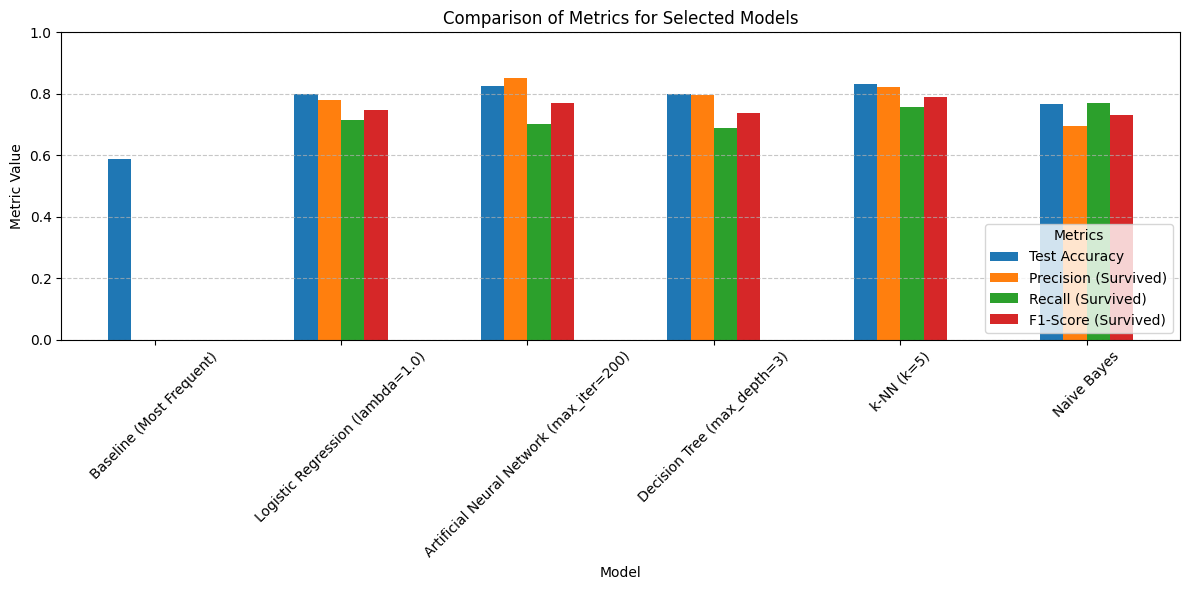

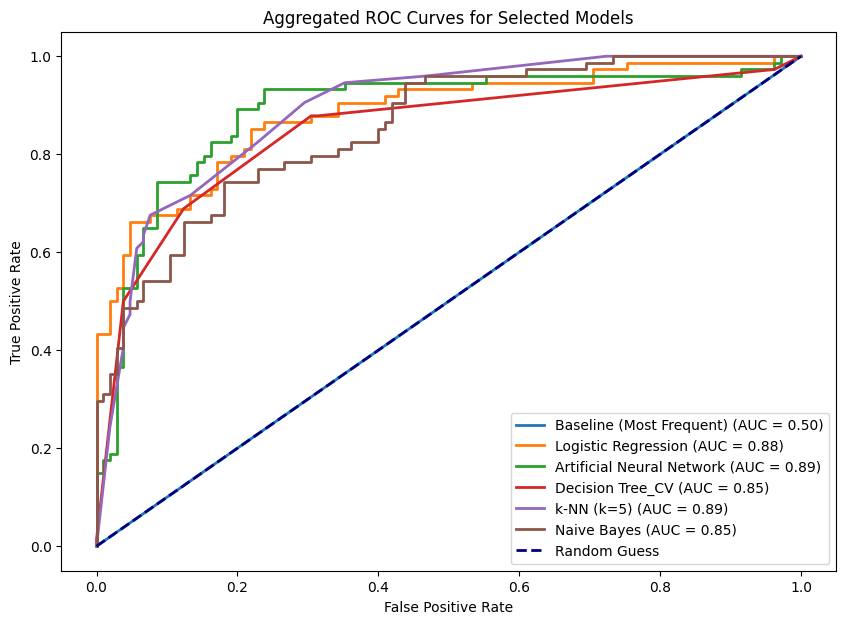

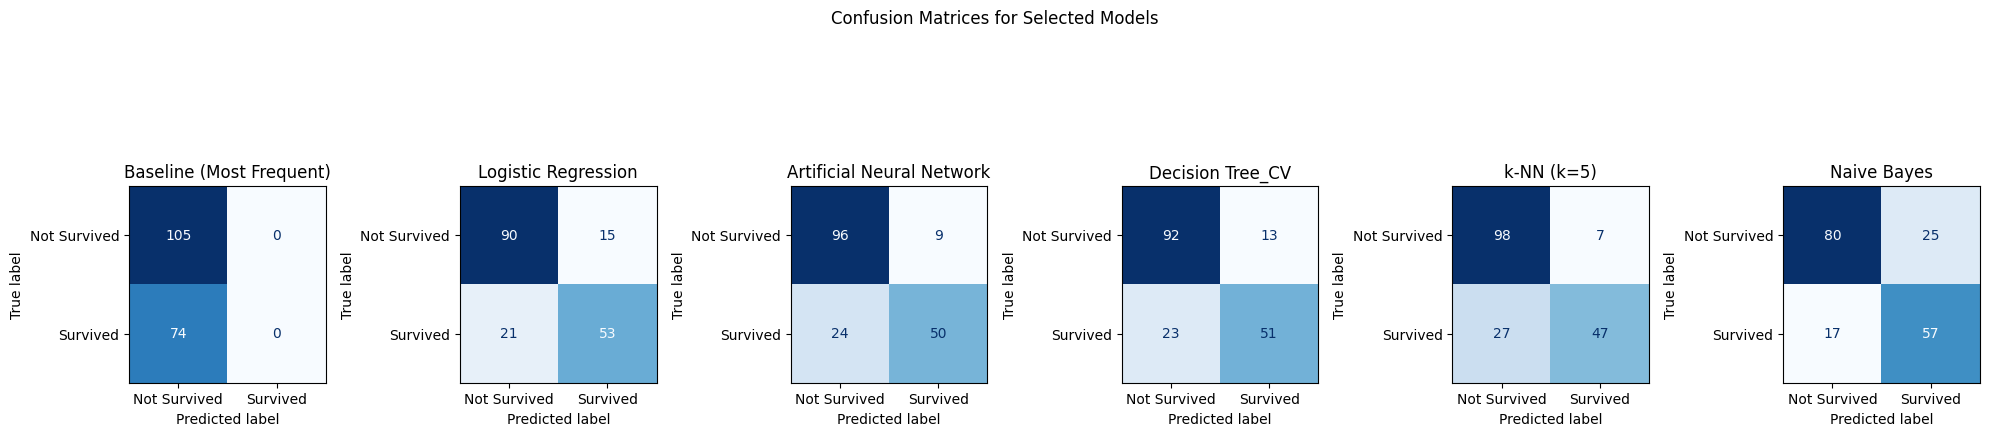

In [28]:
# Define the chosen models and their names based on the comparison table
models = [
    (baseline_model, "Baseline (Most Frequent)"),
    (logistic_regression_model, "Logistic Regression"),  # Logistic Regression chosen (not CV)
    (ann_model, "Artificial Neural Network"),            # ANN chosen (not CV)
    (decision_tree_model_CV, "Decision Tree_CV"),        # Decision Tree_CV chosen (based on *)
    (knn_model, "k-NN (k=5)"),                           # k-NN chosen (not CV)
    (naive_bayes_model, "Naive Bayes")                   # Naive Bayes chosen (no CV)
]

# Select the relevant metrics from the results DataFrame
selected_metrics_df = results_df.set_index("Model")[[
    "Test Accuracy", "Precision (Survived)", "Recall (Survived)", "F1-Score (Survived)"
]]

# Plot aggregated metrics
selected_metrics_df.plot.bar(figsize=(12, 6))
plt.title("Comparison of Metrics for Selected Models")
plt.ylabel("Metric Value")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.ylim(0, 1)  # Ensures all metrics are on the same scale
plt.legend(loc="lower right", title="Metrics")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plot all ROC curves
plt.figure(figsize=(10, 7))
for model, model_name in models:
    if hasattr(model, "predict_proba"):
        y_prob_test = model.predict_proba(X_test_scaled)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob_test)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f"{model_name} (AUC = {roc_auc:.2f})")

# Add diagonal line and labels
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Aggregated ROC Curves for Selected Models")
plt.legend(loc="lower right")
plt.show()

# Plot confusion matrices
fig, axes = plt.subplots(1, len(models), figsize=(20, 5))
for idx, (model, model_name) in enumerate(models):
    y_pred_test = model.predict(X_test_scaled)
    conf_matrix = confusion_matrix(y_test, y_pred_test)
    ax = axes[idx]
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Not Survived", "Survived"])
    disp.plot(cmap="Blues", ax=ax, colorbar=False)
    ax.set_title(model_name)

# Adjust layout
plt.tight_layout()
plt.suptitle("Confusion Matrices for Selected Models", y=1.05)
plt.show()

In [29]:
# Function to compute McNemar's test
def mcnemars_test(model_1_preds, model_2_preds, y_test, model_1_name, model_2_name):

    # Create a 2x2 contingency table
    contingency_table = [[0, 0], [0, 0]]
    
    for true_label, pred_1, pred_2 in zip(y_test, model_1_preds, model_2_preds):
        if pred_1 == true_label and pred_2 == true_label:
            contingency_table[0][0] += 1  # Both correct
        elif pred_1 == true_label and pred_2 != true_label:
            contingency_table[0][1] += 1  # Model 1 correct, Model 2 incorrect
        elif pred_1 != true_label and pred_2 == true_label:
            contingency_table[1][0] += 1  # Model 2 correct, Model 1 incorrect
        else:
            contingency_table[1][1] += 1  # Both incorrect

    # Perform McNemar's test
    result = mcnemar(contingency_table, exact=False)

    return {
        "Model 1": model_1_name,
        "Model 2": model_2_name,
        "Chi2": result.statistic,
        "p-value": result.pvalue,
        "Contingency Table": contingency_table
    }

# Pairwise comparisons
models = {
    "Logistic Regression": logistic_regression_model.predict(X_test_scaled),
    "ANN": ann_model.predict(X_test_scaled),
    "Decision Tree": decision_tree_model_CV.predict(X_test_scaled),
    "k-NN": knn_model.predict(X_test_scaled),
    "Naive Bayes": naive_bayes_model.predict(X_test_scaled),
    "Baseline": baseline_model.predict(X_test_scaled)
}

# Run McNemar's test for all pairwise comparisons
results = []
for model_1_name, model_1_preds in models.items():
    for model_2_name, model_2_preds in models.items():
        if model_1_name != model_2_name:
            result = mcnemars_test(model_1_preds, model_2_preds, y_test, model_1_name, model_2_name)
            results.append(result)

# Convert results to DataFrame for visualization
results_df = pd.DataFrame(results).drop_duplicates(subset=["Model 1", "Model 2"])
print(results_df)

                Model 1              Model 2       Chi2       p-value  \
0   Logistic Regression                  ANN   0.266667  6.055766e-01   
1   Logistic Regression        Decision Tree   0.125000  7.236736e-01   
2   Logistic Regression                 k-NN   0.055556  8.136637e-01   
3   Logistic Regression          Naive Bayes   1.785714  1.814492e-01   
4   Logistic Regression             Baseline  20.132353  7.226390e-06   
5                   ANN  Logistic Regression   0.266667  6.055766e-01   
6                   ANN        Decision Tree   0.363636  5.464936e-01   
7                   ANN                 k-NN   0.000000  1.000000e+00   
8                   ANN          Naive Bayes   2.370370  1.236577e-01   
9                   ANN             Baseline  27.118644  1.913436e-07   
10        Decision Tree  Logistic Regression   0.125000  7.236736e-01   
11        Decision Tree                  ANN   0.363636  5.464936e-01   
12        Decision Tree                 k-NN   0.07